# Design Pattern 7 - Ensembles (Chapter 3)

## Introduction to Design Pattern

Overview:
- Ensemble methods are meta-algorithms that combine several machine learning models as a technique to decrease the bias and/or variance and improve model performance
- This is done by builkding several models with different inductive biases and aggregating their outputs
- Can be an effective means to improve performance and produce predictions that are better than any single model
- Commonly used Ensemble methods include:
    - Bagging
    - Boosting
    - Stacking

Resources: 
- https://github.com/GoogleCloudPlatform/ml-design-patterns/blob/master/03_problem_representation/ensemble_methods.ipynb
- https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205
- Baby weight data --> https://github.com/GoogleCloudPlatform/ml-design-patterns/tree/master/03_problem_representation/data

## Example python implementation

Baby weight prediction problem

In [1]:
import io
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv("./data/babyweight_train.csv")
df

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race
0,7.749249,False,12,Single(1),40,1.0
1,7.561856,True,12,Single(1),40,2.0
2,7.187070,False,12,Single(1),34,3.0
3,6.375769,True,12,Single(1),36,2.0
4,7.936641,False,12,Single(1),35,NaN
...,...,...,...,...,...,...
264559,7.484694,True,50,Single(1),36,2.0
264560,3.373073,True,51,Twins(2),30,1.0
264561,6.680007,True,52,Twins(2),37,1.0
264562,8.124034,True,52,Single(1),42,1.0


In [3]:
eval_df = pd.read_csv("./data/babyweight_eval.csv")

**The 3 parts of Error of an ML model**
1. *Irreducible* error - Inherent model error resulting from noise in dataset, the framing of the problem or bad training examples (e.g. measurement error or confounding factors)
2. Error due to *bias* - Model's inability to learn enough about the relationship between the model's features and labels (*reducible*)
    - Model with high bias oversimplifies the relationship (underfit)
3. Error due to *variance* - Model's inability to generalize on new unseen examples (*reducible*)
    - Model with high variance has learned to much about the training data (overfit)
    
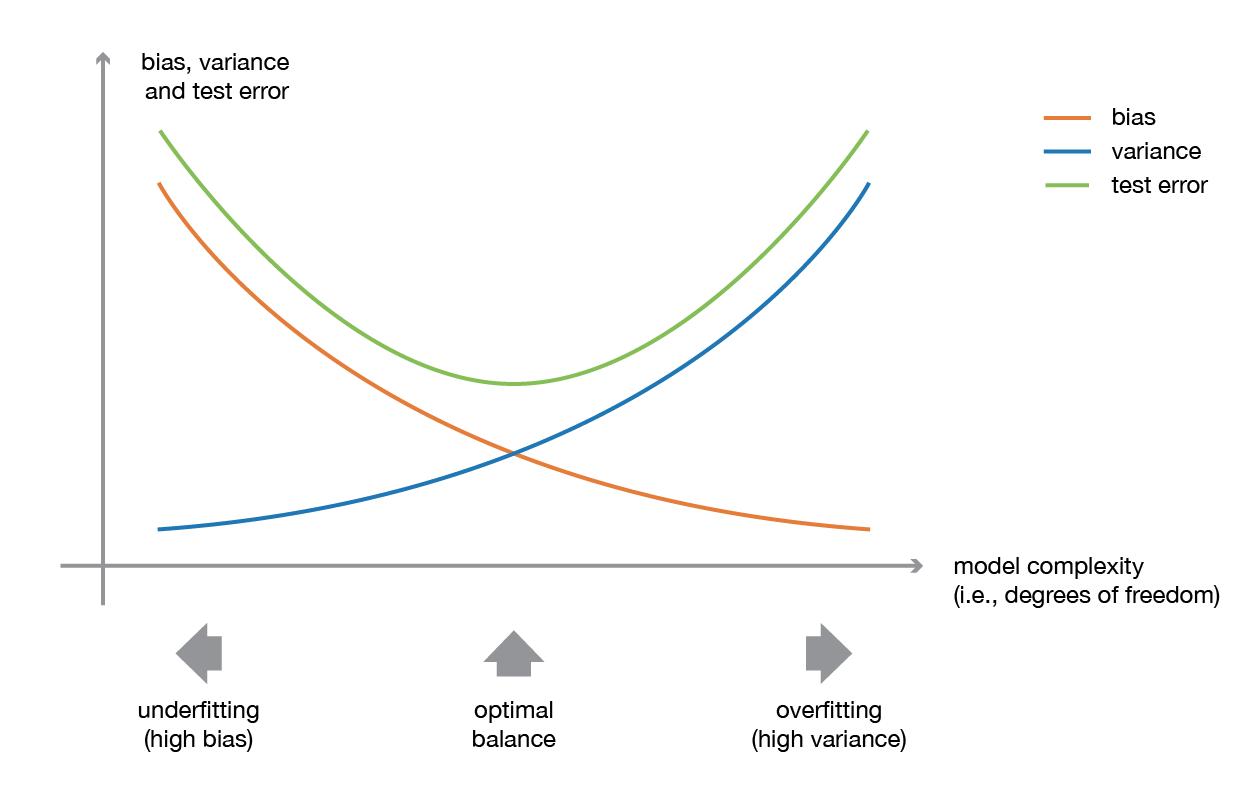
    
Goal of any ml model is to have *low bias* and *low variance* however there is a trade off between the two.
Ensemble methods try to mitigate this bias-variance trade off on small to medium scale problems.

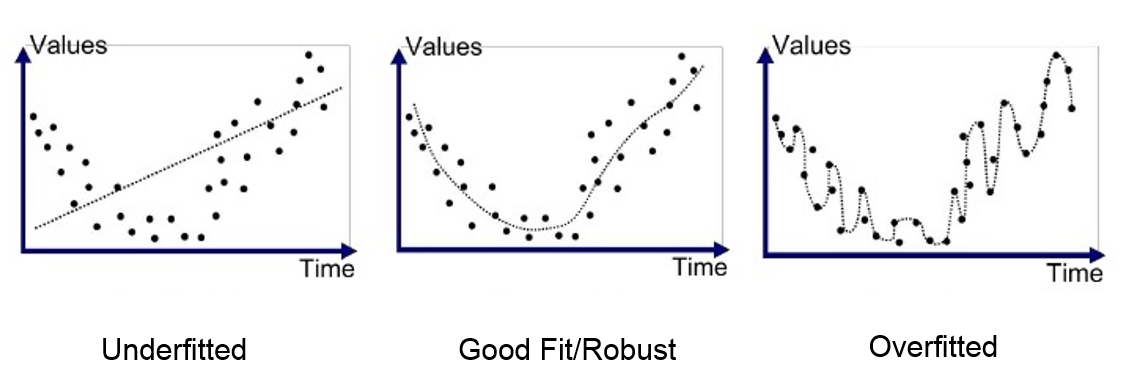

### Bagging
- Short for bootstrap aggregating
- Type of *parallel* ensemble method used to address high variance (overfitting) in ML models
- If there are *k* submodels, then there are *k* seperate datasets used for training each submodel of the ensemble

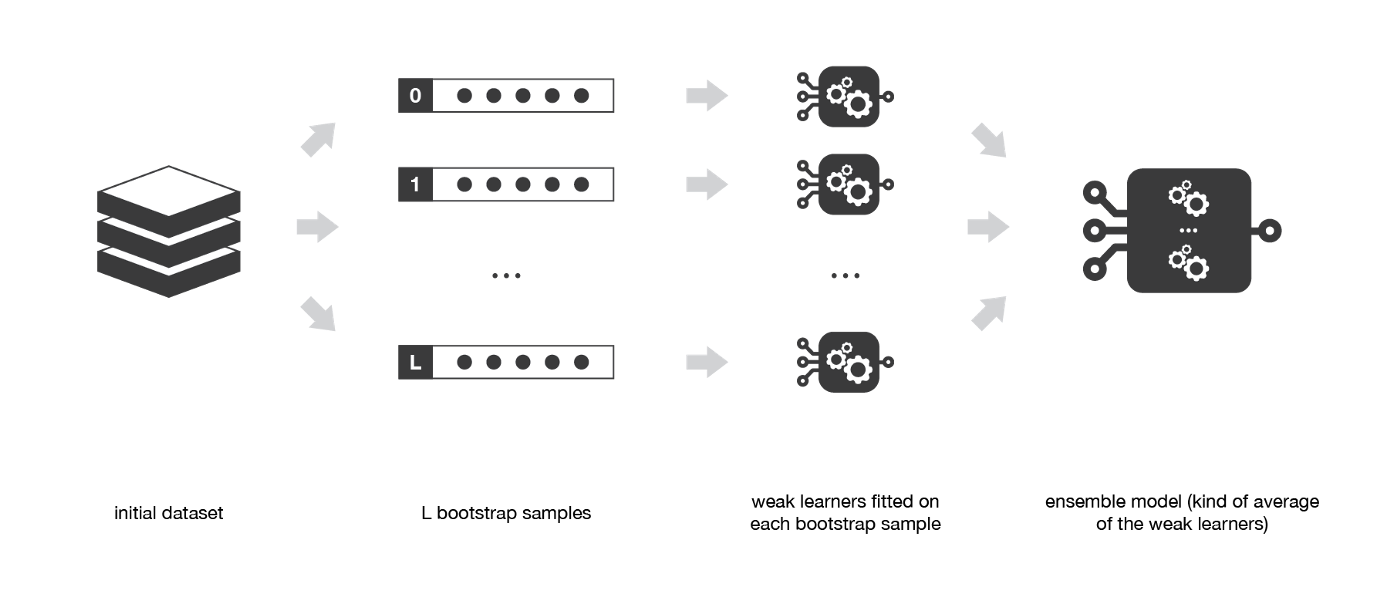

- Each dataset is constructed by random sampling (with replacement) from the original dataset
- This means there is a high probability that any of the *k* datasets will be missing some training examples and/or have repeated training examples
- Aggregation is performed by either taking an average in the case of a regression task or a majority vote in the case of classification

In [4]:
train_X = df[['is_male', 'mother_age', 'gestation_weeks']].astype('int').values
train_Y = df['weight_pounds'].values
test_X = eval_df[['is_male', 'mother_age', 'gestation_weeks']].astype('int').values
test_Y = eval_df['weight_pounds'].values

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Create the model with 50 trees
RF_model = RandomForestRegressor(n_estimators=50, # number of trees in forest
                                 max_features='sqrt', # number of features to consider
                                 bootstrap = True, # whether bootstrap samples are used
                                 n_jobs=-1, # number of jobs to run in parallel
                                 verbose=1) # number of samples to draw from X to train each base estimator

# Fit on training data
RF_model.fit(train_X, train_Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished


RandomForestRegressor(max_features='sqrt', n_estimators=50, n_jobs=-1,
                      verbose=1)

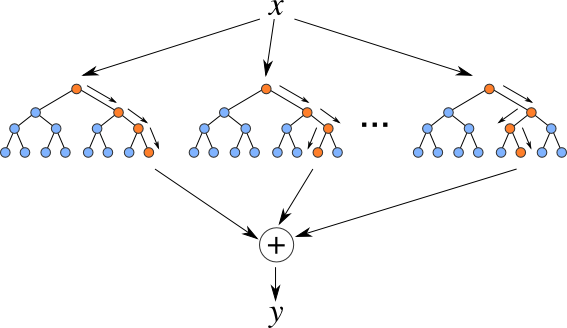

In [6]:
pred_Y = RF_model.predict(test_X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [7]:
from sklearn.metrics import mean_squared_error

mse =mean_squared_error(pred_Y, test_Y)
mse

1.1054336891341803

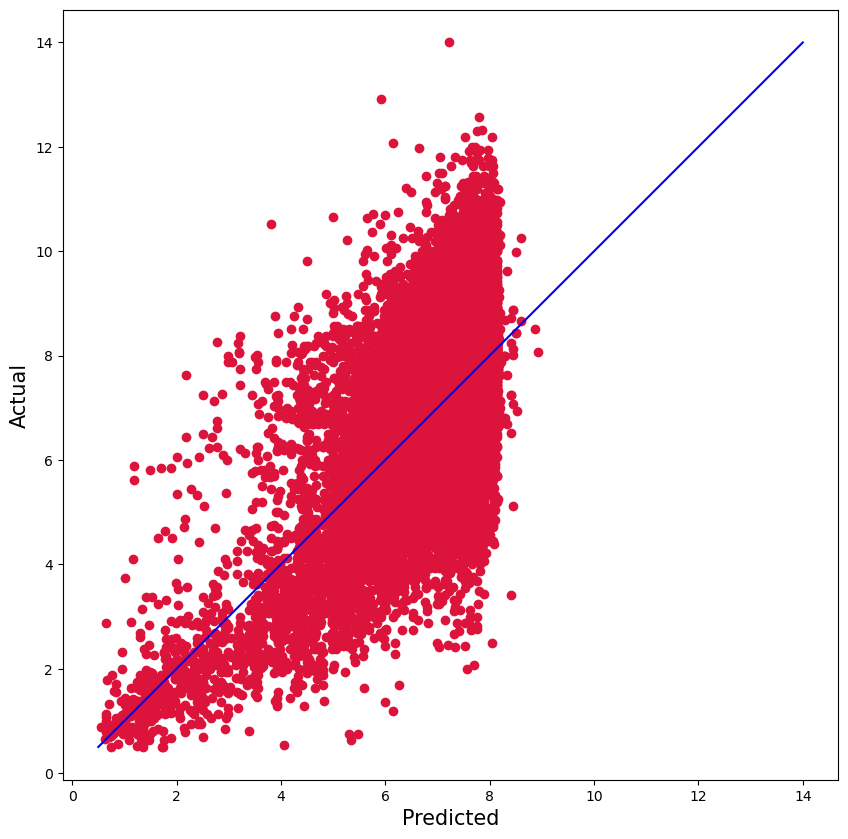

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(pred_Y, test_Y, c='crimson')

p1 = max(max(pred_Y), max(test_Y))
p2 = min(min(pred_Y), min(test_Y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()


## Boosting
- Unlike bagging, boosting constructs an ensemble member with *more* capacity than the individual member models
- Provides a more effective means of reducing bias than variance, hence is better at tackling underfitting in models
- Iteratively improves on a sequence of weak models taking a weighted average to ultimately yield a stronger model

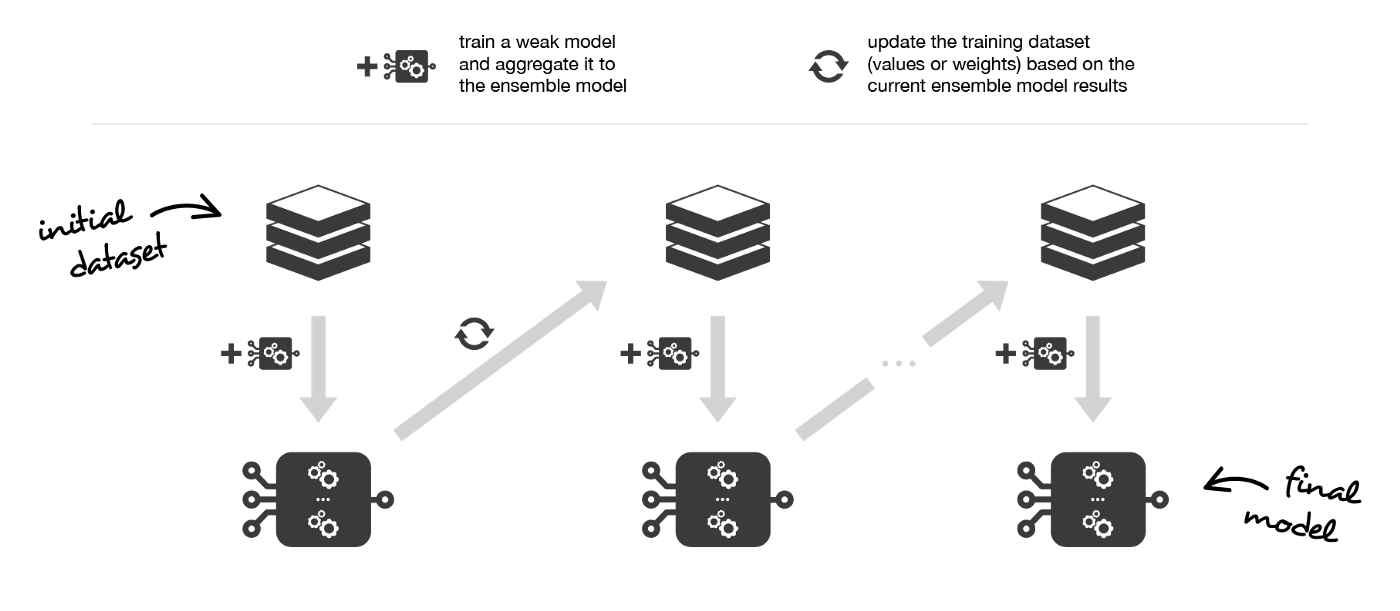

- Firstly, a simple base model `f_0` is selected - for a regression task this could just be the average target value: `f_0 = np.mean(Y_train)`
- For the first iteration step the residuals, `delta_1` are measured and approximated via a seperate model - residual model can be anything (typically is not very sophisticated e.g. a decision tree)
- Approximation provided by residual model is then added to the current prediction
- As this process repeats the residuals tend towards zero and the prediction increasingly gets better at modelling the original dataset

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the Gradient Boosting regressor
GB_model = GradientBoostingRegressor(n_estimators=10, # number of boosting stages to perform
                                     max_depth=None, # maximum depth of the tree
                                     learning_rate=1, # learning rate shrinks the contribution of each tree
                                     criterion='squared_error') # function to measure the quality of a split

# Fit on training data
GB_model.fit(train_X, train_Y)

GradientBoostingRegressor(criterion='squared_error', learning_rate=1,
                          max_depth=None, n_estimators=10)

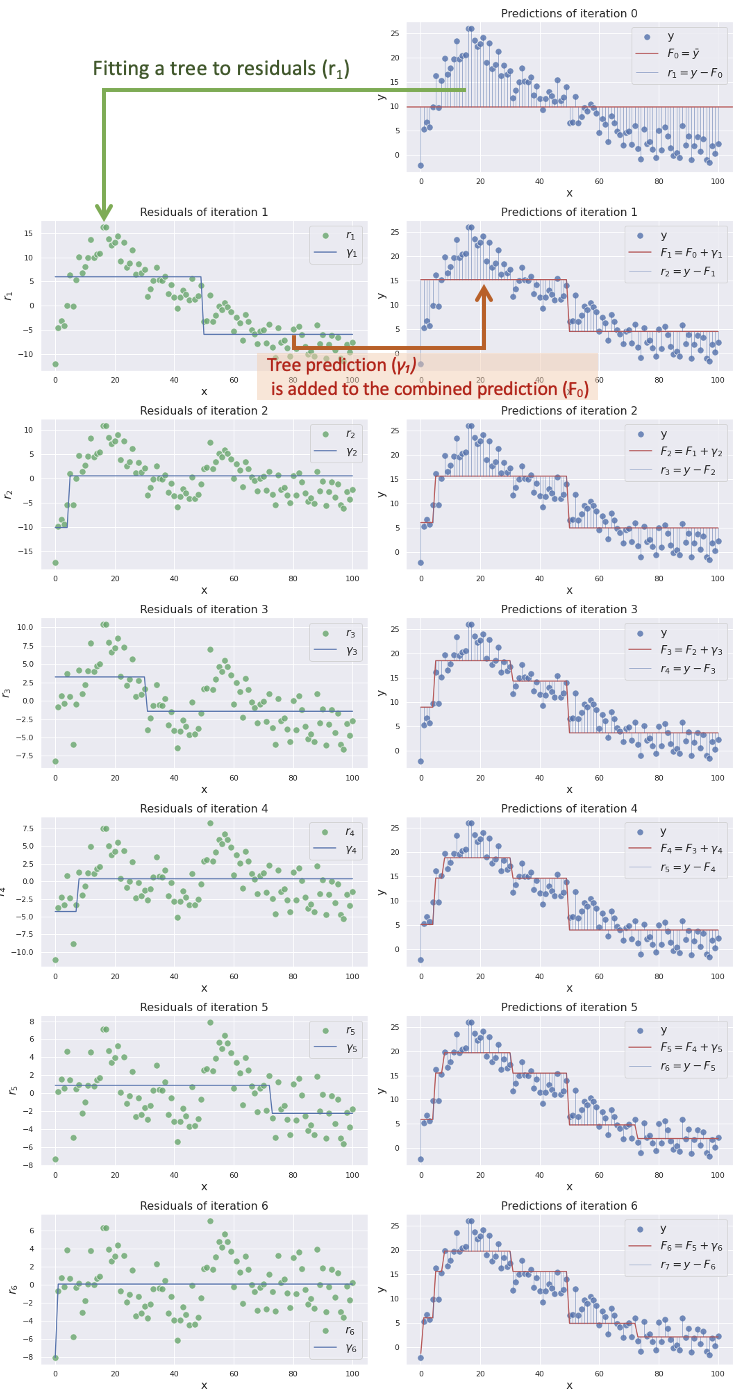

In [10]:
pred_Y_2 = GB_model.predict(test_X)

In [11]:
from sklearn.metrics import mean_squared_error

mse2 =mean_squared_error(pred_Y_2, test_Y)
mse2

1.1063140637507132

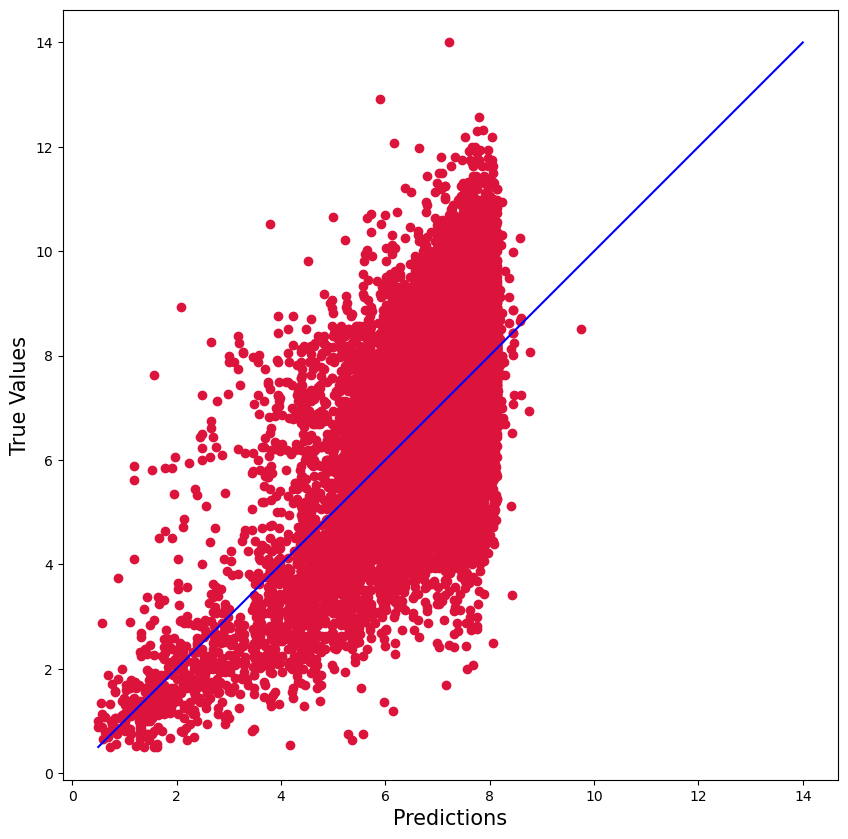

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(pred_Y_2, test_Y, c='crimson')

p1 = max(max(pred_Y_2), max(test_Y))
p2 = min(min(pred_Y_2), min(test_Y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.ylabel('True Values', fontsize=15)
plt.xlabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Stacking
- Combines the outputs of a collection of models to make a prediction 
- The initial models (typically different model types) are trained to completion on the full training datset
- A secondary meta-model is trained using the initial model outputs as features
- This second meta-model learns how to best combine the outcomes of the initial model outputs as features to decrease the training error - Secondary meta-model can be any type of ml model

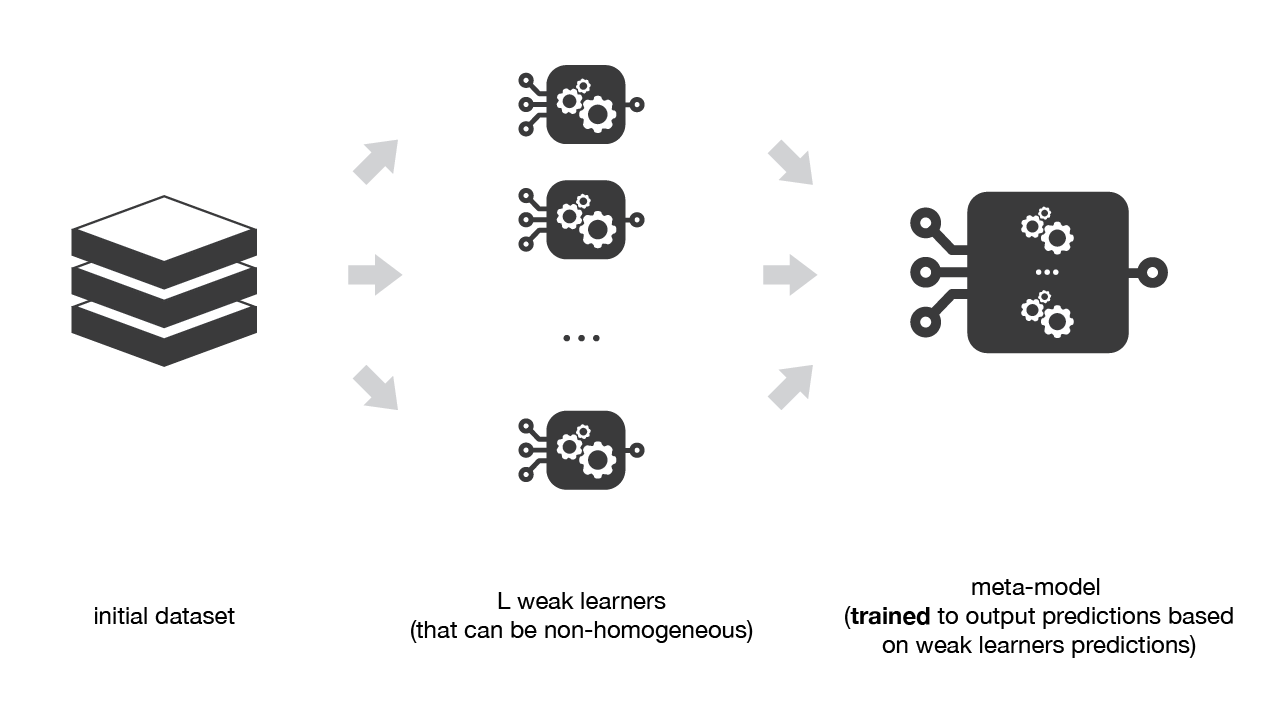

**Create `tf.data` input pipeline**

In [13]:
# Determine CSV, label, and key columns
# Create list of string column headers, make sure order matches.
CSV_COLUMNS = ["weight_pounds",
               "is_male",
               "mother_age",
               "plurality",
               "gestation_weeks",
               "mother_race"]

# Add string name for label column
LABEL_COLUMN = "weight_pounds"

# Set default values for each CSV column as a list of lists.
# Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0], ["0"]]

In [14]:
def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=15, # Artificially small to make examples easier to show.
        label_name=LABEL_COLUMN,
        select_columns=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        num_epochs=1,
        ignore_errors=True)
    return dataset

train_data = get_dataset("./data/babyweight_train.csv")
test_data = get_dataset("./data/babyweight_eval.csv")

In [15]:
def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))

show_batch(train_data)

2022-10-10 13:13:25.643573: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


is_male             : [b'False' b'False' b'False' b'False' b'False' b'False' b'True' b'False'
 b'False' b'True' b'False' b'True' b'False' b'True' b'True']
mother_age          : [17. 16. 15. 17. 17. 16. 18. 16. 15. 16. 15. 16. 18. 15. 17.]
plurality           : [b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)'
 b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)'
 b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)']
gestation_weeks     : [21. 28. 39. 43. 39. 39. 42. 41. 27. 38. 41. 35. 39. 39. 37.]
mother_race         : [b'2.0' b'1.0' b'0' b'1.0' b'2.0' b'0' b'1.0' b'0' b'2.0' b'1.0' b'1.0'
 b'1.0' b'0' b'1.0' b'2.0']


**Create feature columns**

In [16]:
from tensorflow import feature_column as fc

numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': ["Single(1)", 
                  "Twins(2)", 
                  "Triplets(3)",
                  "Quadruplets(4)", 
                  "Quintuplets(5)", 
                  "Multiple(2+)"],
    'is_male' : ["True", 
                 "False", 
                 "Unknown"],
    'mother_race': [str(_) for _ in df.mother_race.unique()]
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
  categorical_columns.append(fc.indicator_column(cat_col))

**Create ensemble models**

In [17]:
from tensorflow import keras
from tensorflow.keras import layers, models, Model

inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}

inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="string")
    for colname in ["is_male", "plurality", "mother_race"]})

dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# model_1
model1_h1 = layers.Dense(50, activation="relu")(dnn_inputs)
model1_h2 = layers.Dense(30, activation="relu")(model1_h1)
model1_output = layers.Dense(1, activation="relu")(model1_h2)
model_1 = tf.keras.models.Model(inputs=inputs, outputs=model1_output, name="model_1")

# model_2
model2_h1 = layers.Dense(64, activation="relu")(dnn_inputs)
model2_h2 = layers.Dense(32, activation="relu")(model2_h1)
model2_output = layers.Dense(1, activation="relu")(model2_h2)
model_2 = tf.keras.models.Model(inputs=inputs, outputs=model2_output, name="model_2")

# model_3
model3_h1 = layers.Dense(32, activation="relu")(dnn_inputs)
model3_output = layers.Dense(1, activation="relu")(model3_h1)
model_3 = tf.keras.models.Model(inputs=inputs, outputs=model3_output, name="model_3")

In [18]:
# fit model on dataset
def fit_model(model):
    # define model
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer='adam', metrics=['mse'])
    # fit model
    model.fit(train_data.shuffle(500), epochs=1)
    
    # evaluate model
    test_loss, test_mse = model.evaluate(test_data)
    print('\n\n{}:\nTest Loss {}, Test RMSE {}'.format(
        model.name, test_loss, test_mse**0.5))
    
    return model

- All the members of the ensemble are trained on the train dataset
- The `fit_model` function takes as arguments a model and the training dataset inputs - this way "members" is a list containing all the trained models in our ensemble 

In [20]:
members = [model_1, model_2, model_3]

# fit and save models
n_members = len(members)

for i in range(n_members):
    # fit model
    model = fit_model(members[i])
    # save model
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename, save_format='tf')
    print('Saved {}\n'.format(filename))

4343/4343 [==============================] - 5s 449us/step - loss: 2.4532 - mse: 2.4532


model_1:
Test Loss 2.453188180923462, Test RMSE 1.5662656801843875
Saved models/model_1.h5

4343/4343 [==============================] - 5s 449us/step - loss: 1.3115 - mse: 1.3115


model_2:
Test Loss 1.3114778995513916, Test RMSE 1.1451977556524426
Saved models/model_2.h5

4343/4343 [==============================] - 2s 447us/step - loss: 2.1330 - mse: 2.1330


model_3:
Test Loss 2.1330056190490723, Test RMSE 1.4604812970555536
Saved models/model_3.h5



**Load the trained models and create the stacked ensemble model**

In [32]:
# load trained models from file
def load_models(n_models):
    all_models = []
    for i in range(n_models):
        filename = 'models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = models.load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [33]:
# load all models
members = load_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
Loaded 3 models


In [34]:
# update all layers in all models to not be trainable
for i in range(n_members):
    model = members[i]
    for layer in model.layers:
        # make not trainable
        layer.trainable = False
        # rename to avoid 'unique layer name' issue
        layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

In [35]:
member_inputs = [model.input for model in members]

# concatenate merge output from each model
member_outputs = [model.output for model in members]
merge = layers.concatenate(member_outputs)
h1 = layers.Dense(30, activation='relu')(merge)
h2 = layers.Dense(20, activation='relu')(h1)
h3 = layers.Dense(10, activation='relu')(h2)
h4 = layers.Dense(5, activation='relu')(h2)
ensemble_output = layers.Dense(1, activation='relu')(h3)
ensemble_model = Model(inputs=member_inputs, outputs=ensemble_output)

# compile
ensemble_model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [36]:
FEATURES = ["is_male", "mother_age", "plurality",
            "gestation_weeks", "mother_race"]

# stack input features for our tf.dataset
def stack_features(features, label):
    for feature in FEATURES:
        for i in range(n_members):
            features['ensemble_' + str(i+1) + '_' + feature] = features[feature]
        
    return features, label

ensemble_data = train_data.map(stack_features).repeat(1)

In [37]:
ensemble_model.fit(ensemble_data.shuffle(500), epochs=1)

17638/17638 [==============================] - 16s 892us/step - loss: 1.1867 - mse: 1.1867


In [38]:
val_loss, val_mse = ensemble_model.evaluate(test_data.map(stack_features))

4343/4343 [==============================] - 3s 718us/step - loss: 1.5684 - mse: 1.5684


In [28]:
print("Validation RMSE: {}".format(val_mse**0.5))

Validation RMSE: 7.361637229431637


## Real world examples

- Bagging --> Any overfitting problem - similar approuch to dropout however in bagging each submodel is independant of one another
- Boosting --> Any underfitting problem
- Stacking --> Also often used to improve underfitting problems - "combines several weak learners"